# Market stage detection with Python and Pandas

## Configuring your development environment

In [1]:
# install the required python packages
# !pip install numpy scipy pandas yfinance matplotlib mplfinance seaborn

## Implementing Stan Weinstein's market stage detector

### Importing requiring packages

In [2]:
# import the necessary packages
from typing import Optional
from typing import Union
from typing import Sequence
from typing import Tuple
from typing import List
from typing import Dict
from enum import Enum
from numpy.typing import ArrayLike
from dataclasses import dataclass
from datetime import timedelta
from datetime import datetime
from scipy import stats
from matplotlib import patches
import matplotlib.pyplot as plt
import mplfinance as mpf
import yfinance as yf
import pandas as pd
import numpy as np

### Helper method to find groups of consecutive integers

In [3]:
def find_consecutive_integers(
        idxs: Union[ArrayLike, Sequence[int]],
        min_consec: int,
        start_offset: int = 0
) -> List[Tuple[int, int]]:
    # check to see if the indexes input is empty
    if len(idxs) == 0:
        # return an empty list
        return []

    # ensure the indexes are an array, then initialize a list to store the
    # groups
    idxs = np.array(idxs)
    groups = []

    # find boundaries in consecutive sequences where the difference between
    # consecutive elements is *not* one, then add in the start and ending
    # indexes to the boundaries
    boundaries = np.where(np.diff(idxs) != 1)[0] + 1
    boundaries = np.concatenate(([0], boundaries, [len(idxs)]))

    # loop over the boundary ranges
    for i in range(0, len(boundaries) - 1):
        # grab the start and end index of the boundary
        start_idx = boundaries[i]
        end_idx = boundaries[i + 1] - 1

        # check to see if the length of the group is greater than our minimum
        # threshold
        if end_idx - start_idx + 1 >= min_consec:
            # update the list of groups
            groups.append((
                int(idxs[start_idx]) + start_offset,
                int(idxs[end_idx]) + start_offset
            ))

    # return the groups
    return groups

### Helper method to compute slope of values in a series

In [4]:
def calculate_slope(series: pd.Series) -> float:
    # check to see if less than two points were provided
    if len(series) < 2:
        # return NaN since slope cannot be computed
        return np.nan

    # check to see if performing linear regression would cause a division by
    # zero error, including (2) *any* of the data points in the series being
    # NaN, or (2) *all* values in the series being equal
    if series.isna().any() or np.all(series == series.iloc[0]):
        # return NaN
        return np.nan
    
    # compute and return the slope for the input data points
    return stats.linregress(np.arange(0, len(series)), series).slope

### Implementing our market `StageDetector` class

In [5]:
class Stage(Enum):
    # define the stage names
    STAGE_I = "stage_1"
    STAGE_II = "stage_2"
    STAGE_III = "stage_3"
    STAGE_IV = "stage_4"

    def integer_value(self, sep: str = "_") -> int:
        # return the integer value of the stage
        return int(self.value.split(sep)[-1])

    def __str__(self):
        # return the string value
        return self.value

In [6]:
# define a custom type for the detected stage ranges where the key is the
# stage name and the value is a list of 2-tuple integers (i.e., the start
# and end indexes for each range belonging to the stage)
DetectedStages = Dict[Stage, List[Tuple[int, int]]]

In [7]:
@dataclass(frozen=True)
class StageDetectorResult:
    # create the data schema for the stage detector resulting, including
    # the processed dataframe and the detected stages
    df: pd.DataFrame
    stages: DetectedStages

In [8]:
class StageDetector:

    def __init__(
            self,
            df: pd.DataFrame,
            fast_ma_size: int = 10,
            slow_ma_size: int = 40,
            min_consec: int = 4,
            slope_window: int = 4,
            rising_threshold: float = 0.0005,
            falling_threshold: float = -0.0005,
            flat_range: float = 0.0002
    ) -> None:
        # store the input dataframe and fast and slow MA sizes
        self.df = df
        self.fast_ma_size = fast_ma_size
        self.slow_ma_size = slow_ma_size

        # store the minimum consecutive threshold to label a date range as a
        # particular stage, along with the slope window used when calculating
        # the slope of MA values
        self.min_consec = min_consec
        self.slope_window = slope_window

        # store the trend thresholds
        self.rising_threshold = rising_threshold
        self.falling_threshold = falling_threshold
        self.flat_range = flat_range

        # determine the fast and slow MA column names
        self.col_fast_ma = f"{self.fast_ma_size}MA"
        self.col_slow_ma = f"{self.slow_ma_size}MA"

        # determine the slope column names
        self.col_fast_ma_slope = f"{self.col_fast_ma}_slope"
        self.col_slow_ma_slope = f"{self.col_slow_ma}_slope"

        # initialize a dictionary to store the detected stages in the input
        # dataframe
        self.stages: DetectedStages = {}

    def detect(self) -> StageDetectorResult:
        # preprocess the dataframe by computing MAs and slope values
        self._compute_indicators()

        # detect each of the four stages
        self._detect_stage_i()
        self._detect_stage_ii()
        self._detect_stage_iii()
        self._detect_stage_iv()

        # construct and return the stage detector result
        return StageDetectorResult(
            df=self.df,
            stages=self.stages
        )

    def _compute_indicators(self) -> None:
        # compute the fast and slow MAs, then drop any NaN rows
        self.df[self.col_fast_ma] = self.df["Close"].rolling(
            window=self.fast_ma_size
        ).mean()
        self.df[self.col_slow_ma] = self.df["Close"].rolling(
            window=self.slow_ma_size
        ).mean()
        self.df = self.df.dropna().copy()

        # calculate slope for both the fast and slow MAs, dropping any NaN rows
        # resulting from the calculations
        self.df[self.col_fast_ma_slope] = self.df[self.col_fast_ma].rolling(
            window=self.slope_window
        ).apply(calculate_slope)
        self.df[self.col_slow_ma_slope] = self.df[self.col_slow_ma].rolling(
            window=self.slope_window
        ).apply(calculate_slope)
        self.df = self.df.dropna().copy()

    def _detect_stage_i(self) -> None:
        # detect stage I conditions where (1) the fast MA is rising, (2) the
        # fast MA is below slow MA, and (3) the slow MA is flattening out
        idxs = np.where(
            (self.df[self.col_fast_ma] < self.df[self.col_slow_ma]) &
            (self.df[self.col_fast_ma_slope] > self.rising_threshold) &
            (np.abs(self.df[self.col_slow_ma]) > self.flat_range)
        )[0]

        # update the stages dictionary
        self.stages[Stage.STAGE_I] = find_consecutive_integers(
            idxs,
            min_consec=self.min_consec
        )

    def _detect_stage_ii(self) -> None:
        # detect stage II conditions where (1) the fast MA is rising, (2) the
        # fast MA is above the slow MA, and (3) the slow MA is also rising
        idxs = np.where(
            (self.df[self.col_fast_ma] > self.df[self.col_slow_ma]) &
            (self.df[self.col_fast_ma_slope] > self.rising_threshold) &
            (self.df[self.col_slow_ma_slope] > self.rising_threshold)
        )[0]

        # update the stages dictionary
        self.stages[Stage.STAGE_II] = find_consecutive_integers(
            idxs,
            min_consec=self.min_consec
        )

    def _detect_stage_iii(self) -> None:
        # detect stage III conditions where (1) the fast MA is heading down,
        # (2) the fast MA is still above the slow MA, and (3) the slow MA is
        # flattening out
        idxs = np.where(
            (self.df[self.col_fast_ma] > self.df[self.col_slow_ma]) &
            (self.df[self.col_fast_ma_slope] < self.falling_threshold) &
            (np.abs(self.df[self.col_slow_ma]) > self.flat_range)
        )[0]

        # update the stages dictionary
        self.stages[Stage.STAGE_III] = find_consecutive_integers(
            idxs,
            min_consec=self.min_consec
        )

    def _detect_stage_iv(self) -> None:
        # detect stage IV conditions where (1) the fast MA is below the slow
        # MA, (2) the fast MA is down trending, and (3) the slow MA is also
        # down trending
        idxs = np.where(
            (self.df[self.col_fast_ma] < self.df[self.col_slow_ma]) &
            (self.df[self.col_fast_ma_slope] < self.falling_threshold) &
            (self.df[self.col_slow_ma_slope] < self.falling_threshold)
        )[0]

        # update the stages dictionary
        self.stages[Stage.STAGE_IV] = find_consecutive_integers(
            idxs,
            min_consec=self.min_consec
        )

    def what_stage(self, input_date: datetime) -> Optional[Stage]:
        # grab the row index of the input date
        row_idx = self.df.index.get_loc(input_date)

        # loop over the computed stage indexes
        for (stage_name, periods) in self.stages.items():
            # loop over the starting and ending indexes for the period in the
            # current stage
            for (start, end) in periods:
                # check to see if the input date index falls within this range
                if start <= row_idx <= end:
                    # return stage name
                    return stage_name

        # otherwise, no stage could be detected
        return None

### Plotting our market stage detections

In [9]:
# define default stage color mapping for visualization
DEFAULT_STAGE_COLORS = {
    Stage.STAGE_I: "yellowgreen",
    Stage.STAGE_II: "seagreen",
    Stage.STAGE_III: "indigo",
    Stage.STAGE_IV: "red",
}

In [10]:
def plot_stage_detections(
        stage_result: StageDetectorResult,
        title: str,
        stage_colors: Optional[Dict[str, str]] = None
) -> plt.Figure:
    # check if the stage colors has not been supplied
    if stage_colors is None:
        # use the default stage colors
        stage_colors = DEFAULT_STAGE_COLORS

    # initialize a new figure, then create a subplot for the stages
    fig = mpf.figure(figsize=(14, 7), style="yahoo")
    ax = plt.subplot(1, 1, 1)

    # take the rectangle height to be the highest high in the dataframe
    rect_height = stage_result.df["High"].max()

    # loop over the stages and periods
    for (stage, periods) in stage_result.stages.items():
        # loop over the periods in each stage
        for (start, end) in periods:
            # create a rectangle to visualize the stage
            rect = patches.Rectangle(
                xy=(start, 0),
                width=end - start,
                height=rect_height,
                color=stage_colors[stage],
                alpha=0.25
            )

            # compute the center x-coordinate of the rectangle and use it to
            # draw the stage name inside the rectangle
            cx = start + ((end - start) / 2.0)
            ax.annotate(
                str(stage.integer_value()),
                xy=(cx, rect_height * 0.95),
                color="black",
                weight="bold",
                fontsize=8,
                ha="center"
            )

            # add the rectangle and text to the axis
            ax.add_patch(rect)
            ax.autoscale_view()

    # create additional plots for the moving averages
    addt_plots = [
        mpf.make_addplot(
            stage_result.df["10MA"],
            color="royalblue",
            ax=ax
        ),
        mpf.make_addplot(
            stage_result.df["40MA"],
            color="maroon",
            ax=ax
        ),
    ]

    # plot the candlesticks with the MAs
    mpf.plot(
        stage_result.df,
        ax=ax,
        addplot=addt_plots,
        type="candle"
    )

    # set the figure title and convert to a tight layout
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()

    # return the figure of stage detections
    return fig

## Examples of market stage detection

In [11]:
# define the tickers we're interested in
tickers = ["SPY", "NVDA", "XOM"]

# set the start and end date of history requests
end_date = datetime(year=2025, month=3, day=7)
start_date = end_date - timedelta(days=365 * 4)

In [12]:
# download market data for the tickers
df = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    interval="1wk",
    group_by="ticker",
    auto_adjust=True,
    progress=False
)

### S&P 500 (Stage II uptrend)

In [13]:
# apply stage detection to the S&P 500
stage_detector = StageDetector(df["SPY"].copy())
result = stage_detector.detect()

In [14]:
# show the resulting dataframe
result.df

Price,Open,High,Low,Close,Volume,10MA,40MA,10MA_slope,40MA_slope
Date,,,,,,,,,
2021-12-27,450.419443,457.041296,450.371747,453.186493,279152600,442.683350,417.094979,2.301824,1.912731
2022-01-03,454.465082,457.976403,443.349156,444.723145,420356300,443.489404,418.751754,1.888484,1.905287
2022-01-10,441.488537,451.507187,435.668172,443.415924,448334500,443.282379,420.118892,0.930888,1.666163
2022-01-17,438.664172,438.874088,417.873110,417.901733,543717600,440.643738,420.711904,-0.632586,1.221791
2022-01-24,412.224507,423.683943,401.471166,421.689758,920508000,438.229865,421.411897,-1.841726,0.857344
...,...,...,...,...,...,...,...,...,...
2025-02-03,590.892458,606.306112,588.719003,598.968201,216528100,595.479822,563.541057,1.061890,2.566276
2025-02-10,602.218421,609.157508,596.714958,607.871399,169013200,595.871527,565.880482,0.375613,2.378936
2025-02-17,609.047878,611.390805,597.672064,598.140686,170833900,595.647876,567.764098,0.096803,2.206634


In [15]:
# show the detected stages
result.stages

{<Stage.STAGE_I: 'stage_1'>: [(31, 38), (47, 53)],
 <Stage.STAGE_II: 'stage_2'>: [(64, 89), (99, 165)],
 <Stage.STAGE_III: 'stage_3'>: [(3, 9), (90, 98)],
 <Stage.STAGE_IV: 'stage_4'>: [(17, 30), (39, 46)]}

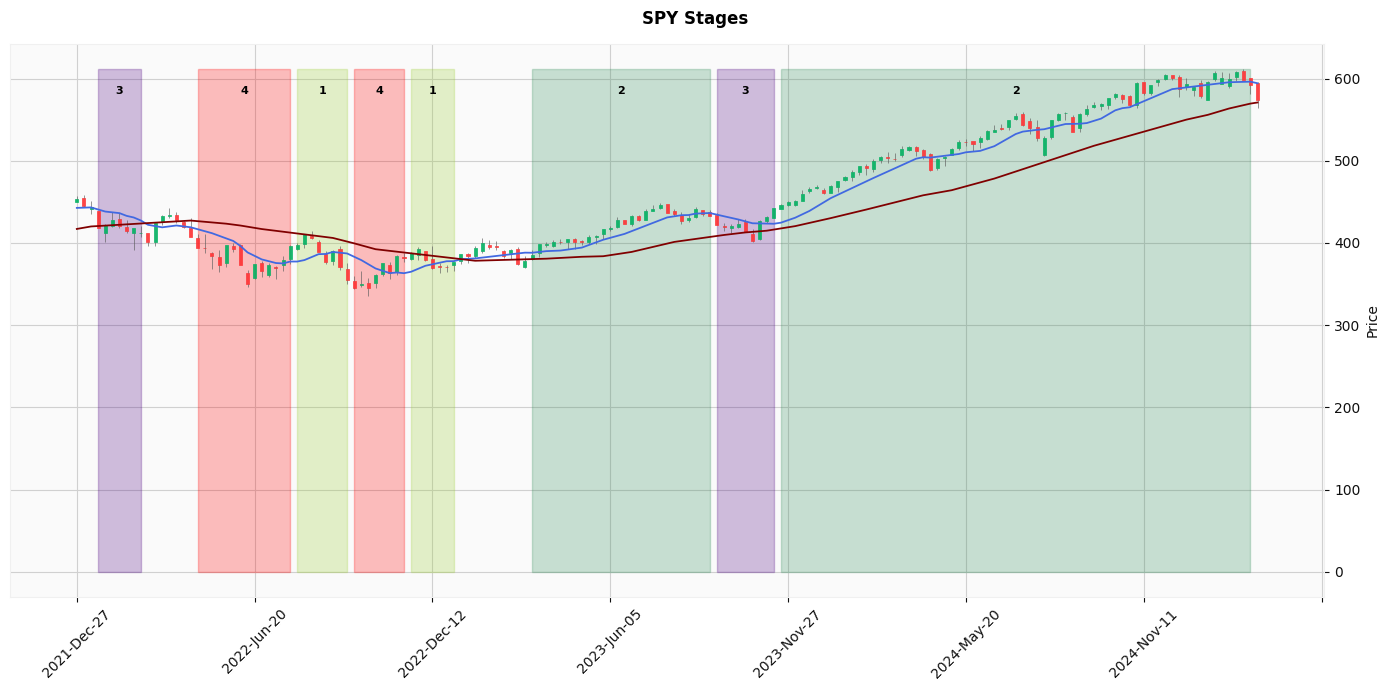

In [16]:
# plot the stages
fig = plot_stage_detections(result, "SPY Stages")

### NVDA (Stage III decline)

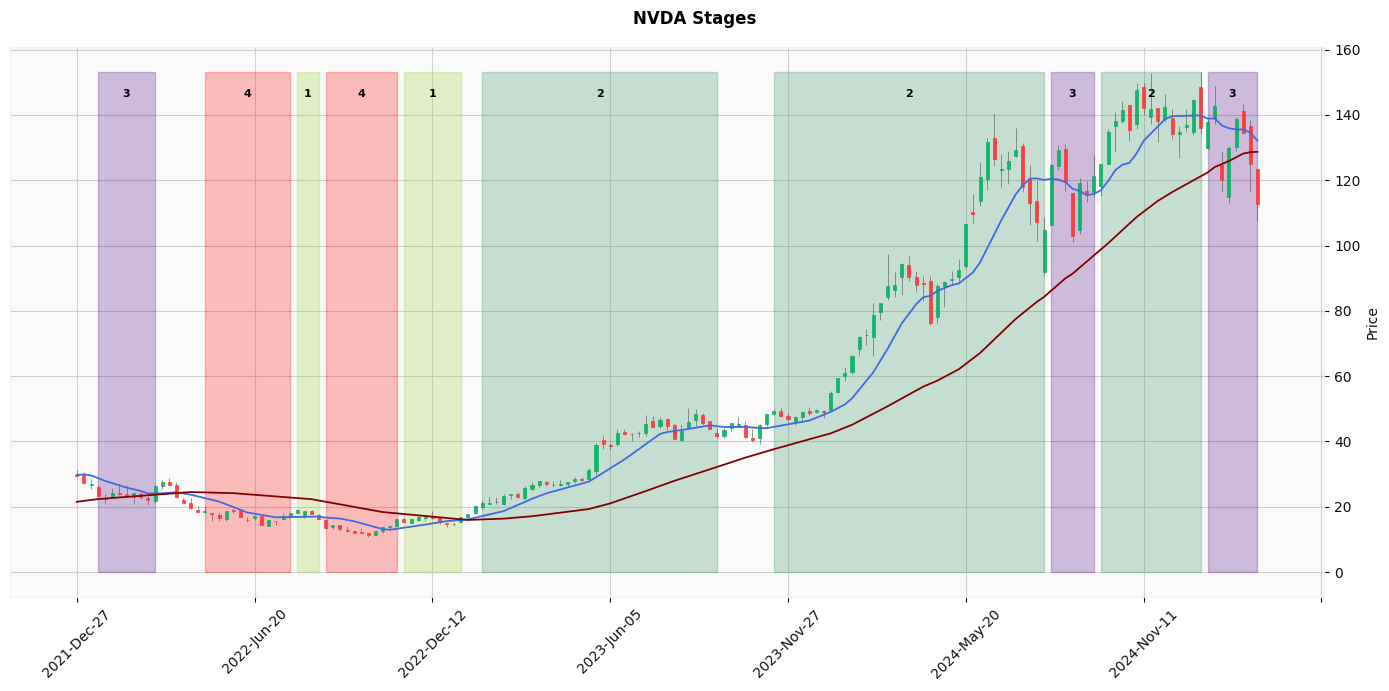

In [17]:
# apply stage detection to NVDA
stage_detector = StageDetector(df["NVDA"].copy())
result = stage_detector.detect()

# plot the stages
fig = plot_stage_detections(result, "NVDA Stages")

### XOM (Stage IV decline)

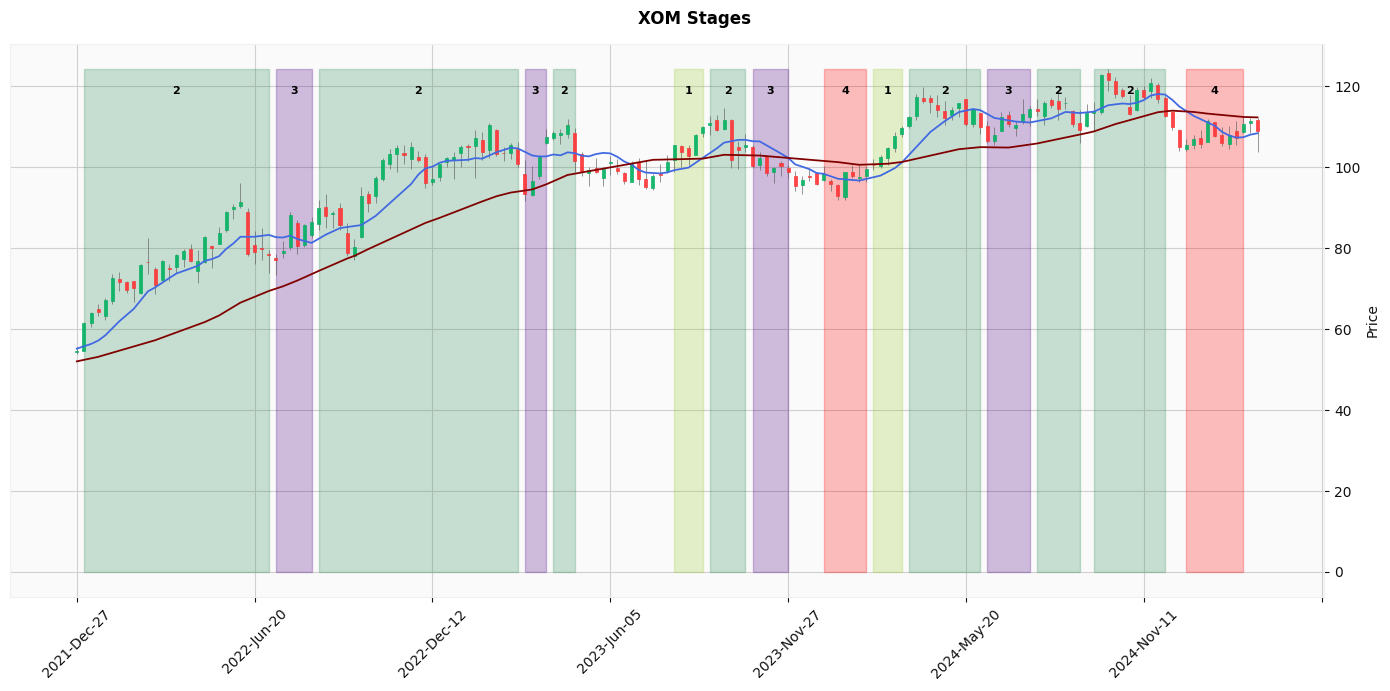

In [18]:
# apply stage detection to XOM
stage_detector = StageDetector(df["XOM"].copy())
result = stage_detector.detect()

# plot the stages
fig = plot_stage_detections(result, "XOM Stages")